In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import re
import timm
import lpips
from tqdm import tqdm
import numpy as np

def get_identifier(filename):
    match = re.search(r'p\d+', filename)  # Match pattern 'p' followed by digits
    return match.group(0) if match else None

# Custom Dataset class for loading images on-the-fly
class PairedImageDataset(Dataset):
    def __init__(self, inputs, targets, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.sar_images = [f for f in os.listdir(inputs) if f.endswith(('.jpg', '.png'))]
        self.optical_images = [f for f in os.listdir(targets) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

        # Ensure that the lists are ordered
        self.sar_images.sort()
        self.optical_images.sort()

        # Check if the images match in both folders
        self.sar_images = {get_identifier(f): f for f in self.sar_images}
        self.optical_images = {get_identifier(f): f for f in self.optical_images}

        common_ids = set(self.sar_images.keys()) & set(self.optical_images.keys())
        self.sar_images = [self.sar_images[i] for i in common_ids]
        self.optical_images = [self.optical_images[i] for i in common_ids]

    def __len__(self):
        return len(self.sar_images)

    def __getitem__(self, idx):
        sar_image_path = os.path.join(self.inputs, self.sar_images[idx])
        optical_image_path = os.path.join(self.targets, self.optical_images[idx])

        # Open images
        sar_image = Image.open(sar_image_path).convert('L')  # Grayscale
        optical_image = Image.open(optical_image_path).convert('RGB')  # RGB

        # Resize images
        sar_image = sar_image.resize((224, 224))
        optical_image = optical_image.resize((224, 224))

        # Convert grayscale to RGB by duplicating channels
        sar_image = sar_image.convert('RGB')  # This will now have 3 channels

        if self.transform:
            sar_image = self.transform(sar_image)
            optical_image = self.transform(optical_image)

        # Convert to numpy arrays and then to torch tensors
        sar_image = np.array(sar_image).astype(np.float32)  # Now it has 3 channels
        optical_image = np.array(optical_image).astype(np.float32)

        # Convert to torch tensors
        sar_image = torch.tensor(sar_image).permute(2, 0, 1)  # [3, 224, 224]
        optical_image = torch.tensor(optical_image).permute(2, 0, 1)  # [3, 224, 224]

        return sar_image, optical_image

# Define your models and training setup
class SwinEncoder(nn.Module):
    def __init__(self):
        super(SwinEncoder, self).__init__()
        self.swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True, features_only=True)

    def forward(self, x):
        # Extract multiple feature maps
        features = self.swin_model(x)  # This will give you a list of feature maps at different stages
        print("Swin Encoder Feature Shapes:", [f.shape for f in features])  # Check shapes of all features

        # Permute the features to match the PyTorch convention [batch_size, channels, height, width]
        x1 = features[1].permute(0, 3, 1, 2)  # High-resolution feature map
        x2 = features[2].permute(0, 3, 1, 2)  # Medium-resolution feature map
        x3 = features[3].permute(0, 3, 1, 2)  # Low-resolution feature map

        return x1, x2, x3


In [9]:
class HRNetDecoder(nn.Module):
    def __init__(self, num_classes=3):
        super(HRNetDecoder, self).__init__()

        # Define multiple resolution branches (high, medium, low resolution)
        self.branch1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1)
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        )

        # Upsample lower resolutions to match higher resolution
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)

        # Final fusion
        self.final_fusion = nn.Sequential(
            nn.Conv2d(256 + 512 + 1024, 256, kernel_size=1),  # Fuse the features
            nn.ReLU(inplace=True),
            nn.Conv2d(256, num_classes, kernel_size=1)  # Final prediction
        )

        # Upsample to match target size
        self.upsample_final = nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True)

    def forward(self, x1, x2, x3):
        # Process each resolution
        out1 = self.branch1(x1)  # High-resolution branch
        out2 = self.branch2(x2)  # Medium-resolution branch
        out3 = self.branch3(x3)  # Low-resolution branch

        # Upsample lower resolutions
        out2 = self.upsample2(out2)
        out3 = self.upsample3(out3)

        # Fuse all resolutions
        fused = torch.cat([out1, out2, out3], dim=1)

        # Final prediction
        output = self.final_fusion(fused)

        # Upsample to match target size (224x224)
        output = self.upsample_final(output)

        return output

# Example usage: Adjust HRNetDecoder initialization in the model
class SwinHRNetModel(nn.Module):
    def __init__(self):
        super(SwinHRNetModel, self).__init__()
        self.encoder = SwinEncoder()  # Your Swin Transformer Encoder
        self.decoder = HRNetDecoder(num_classes=3)  # HRNet Decoder

    def forward(self, x):
        # Assuming Swin Encoder outputs multiple resolutions
        x1, x2, x3 = self.encoder(x)  # Extract features from different resolution levels

        # Decode using HRNet
        output = self.decoder(x1, x2, x3)
        return output

def visualize_single_output(model, dataloader, index=0):
    model.eval()
    with torch.no_grad():
        # Get a specific batch of inputs and targets
        inputs, targets = next(iter(dataloader))
        inputs = inputs.to(device)

        # Generate outputs
        outputs = model(inputs)

        # Select the output image at the specified index
        output_image = outputs[index].cpu().numpy().transpose(1, 2, 0)  # [height, width, channels]
        output_image = (output_image).astype(np.uint8)  # Scale to 0-255

        # Display the output image
        plt.imshow(output_image)
        plt.axis('off')
        plt.title(f'Generated Image at Index {index}')
        plt.show()

In [10]:
# Set up the dataset and dataloader
inputs = "Dataset/SAR"
targets = "Dataset/Optical"

# Use the custom dataset and DataLoader for batch loading
dataset = PairedImageDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinHRNetModel().to(device)
criterion = nn.MSELoss()
perceptual_loss = lpips.LPIPS(net='vgg').to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 200
epoch_list = []
loss_list = []
if os.path.exists("model/model.pt"):
    model.load_state_dict(torch.load('model/model.pt', map_location=torch.device('cpu')))
    model.eval()
else:
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, targets)
            percep_loss = perceptual_loss(outputs, targets).mean()
            total_loss = loss + 0.1 * percep_loss
            epoch_loss += total_loss.item()
            # Backward pass and optimization
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        # Append the epoch number and loss to the lists for tracking
        epoch_list.append(epoch + 1)
        loss_list.append(epoch_loss / len(dataloader))
        # Print the average loss for this epoch
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")
        # Visualization after each epoch (visualize only the first image in the batch)
        if (epoch + 1) % 25 == 0:
            visualize_single_output(model, dataloader, index=0)  # Change index to visualize different images
print("Training completed.")

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\lpips\weights\v0.1\vgg.pth


C:\Users\HP\AppData\Local\Temp/ipykernel_12972/1248143599.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/model.pt', map_locatio

Training completed.


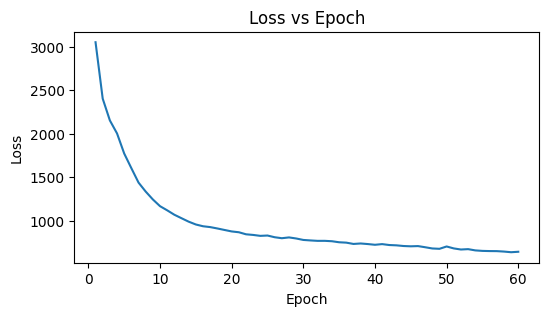

In [11]:
graph = np.load("model/graph.npy")
epoch, loss = graph
#plot the loss_list and epoch_list
plt.figure(figsize=(6, 3))
plt.plot(epoch, loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


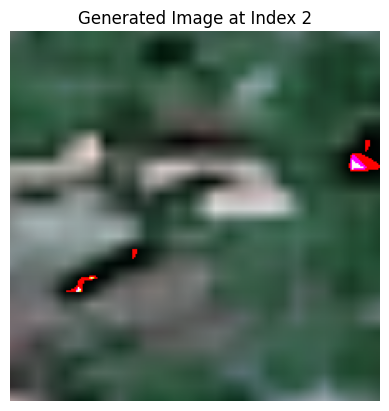

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


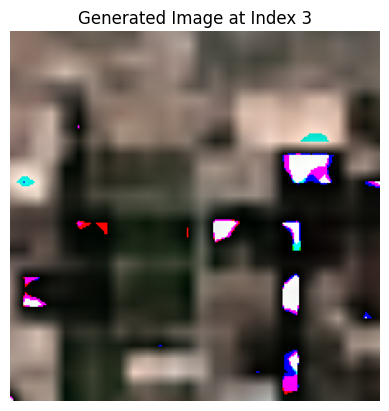

Swin Encoder Feature Shapes: [torch.Size([16, 56, 56, 128]), torch.Size([16, 28, 28, 256]), torch.Size([16, 14, 14, 512]), torch.Size([16, 7, 7, 1024])]


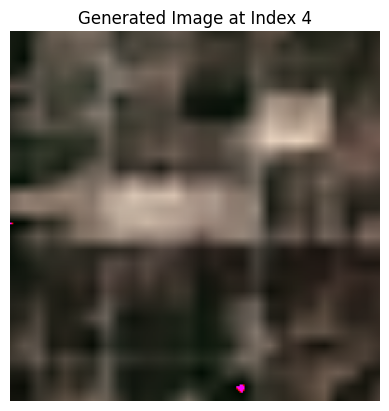

In [12]:
#visualizing predicted image from test data
for i in range(2,5):
    visualize_single_output(model, dataloader, index=i)  # Change index to visualize different images

In [6]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, device):
    # Open and process the grayscale input image (256x256)
    image = Image.open(image_path).convert('L')  # Open grayscale image
    image = image.resize((224, 224))  # Resize to match the model input size
    image = image.convert('RGB')  # Convert grayscale to RGB by duplicating channels

    # Convert image to numpy and then to torch tensor (without normalization)
    image_np = np.array(image).astype(np.float32)  # Convert to numpy
    image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to(device)  # Add batch dimension and permute

    # Run the model in evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)  # Forward pass
        output_image = output.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch and convert to numpy

    # Convert the output to an image format
    output_image = np.clip(output_image, 0, 255).astype(np.uint8)  # Clip values to 0-255 and convert to uint8

    # Display the result
    plt.imshow(output_image)
    plt.axis('off')
    plt.title('Predicted Color Image')
    plt.show()


Swin Encoder Feature Shapes: [torch.Size([1, 56, 56, 128]), torch.Size([1, 28, 28, 256]), torch.Size([1, 14, 14, 512]), torch.Size([1, 7, 7, 1024])]


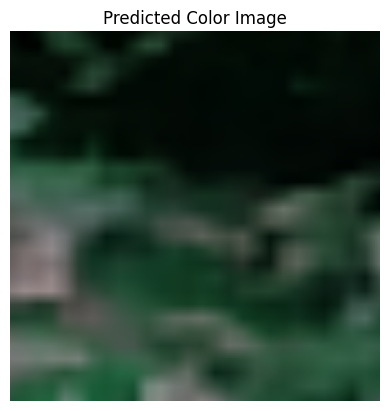

In [7]:
# input test SAR image along with model to colorize image 
predict_single_image(model,'testImages/1.png', device)

Swin Encoder Feature Shapes: [torch.Size([1, 56, 56, 128]), torch.Size([1, 28, 28, 256]), torch.Size([1, 14, 14, 512]), torch.Size([1, 7, 7, 1024])]


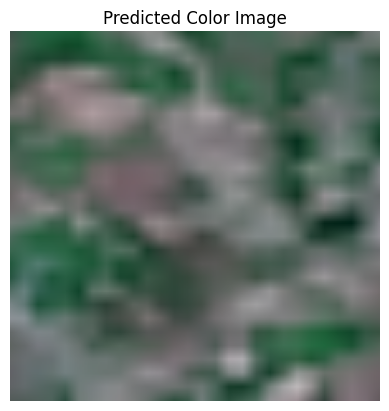

In [15]:
# input test SAR image along with model to colorize image 
predict_single_image(model,'testImages/2.png', device)

Swin Encoder Feature Shapes: [torch.Size([1, 56, 56, 128]), torch.Size([1, 28, 28, 256]), torch.Size([1, 14, 14, 512]), torch.Size([1, 7, 7, 1024])]


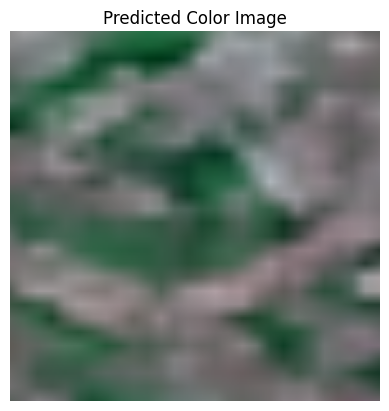

In [16]:
# input test SAR image along with model to colorize image 
predict_single_image(model,'testImages/3.png', device)